# Format ALR data to apply NPP CbPM and VgPM algorithms

I am processing the data of ALR ecoPUK, the matchup between ecopuk output and navigation time and position is done using the R script ALR_Ecopuk for ALR4 and ALR6_ecopuk. I'm starting with ALR6 here. 
I need to :
1. Profile the ALR data
2. Find the best daily PAR values
3. Compute bbp from beta
4. Unquench chlorophyll

## Profiling ALR data

I will use the glider profiling function. 

In [1]:
import polars as pl
import numpy as np
import os
import xarray as xr
import glidertools as gt

In [2]:
dat = pl.read_csv("../output/ALR6_fluorometer_data.csv", infer_schema_length=None)

# Convert datetime to actual datetime format, handling ISO 8601 with 'Z' suffix
dat = dat.with_columns(
    pl.col("datetime").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%SZ", strict=False)
)

#cast depth as float returning NA for non-convertible values    
dat = dat.with_columns(
    pl.col("depth")
    .cast(pl.Float64, strict=False)
    .fill_null(strategy="forward")
)

In [3]:
def find_profiles(
    df,
    gradient_thresholds: list,
    filter_win_sizes=["20s", "10s"],
    time_col="TIME",
    depth_col="DEPTH",
):
    """
    Identifies vertical profiles in oceanographic or similar data by analyzing depth gradients over time.

    This function processes depth-time data to identify periods where an instrument is performing
    vertical profiling based on gradient thresholds. It handles data interpolation, calculates vertical
    velocities, applies median filtering, and assigns unique profile numbers to identified profiles.

    Parameters
    ----------
    df : polars.DataFrame
        Input dataframe containing time and depth measurements
    gradient_thresholds : list
        Two-element list [positive_threshold, negative_threshold] defining the vertical velocity
        range (in meters/second) that is NOT considered part of a profile. typical values are around [0.02, -0.02]
    filter_win_sizes : list, default= ['20s', '10s']
        Window sizes for the compound filter applied to gradient calculations, in Polars duration format.
        index 0 controls the rolling median window size and index 1 controls the rolling mean window size.
    time_col : str, default='TIME'
        Name of the column containing timestamp data
    depth_col : str, default='DEPTH'
        Name of the column containing depth measurements

    Returns
    -------
    polars.DataFrame
        Dataframe with additional columns:
        - 'dt': Time difference between consecutive points (seconds)
        - 'dz': Depth difference between consecutive points (meters)
        - 'grad': Vertical velocity (dz/dt, meters/second)
        - 'smooth_grad': Median-filtered vertical velocity
        - 'is_profile': Boolean indicating if a point belongs to a profile
        - 'profile_num': Unique identifier for each identified profile (0 for non-profile points)

    Notes
    -----
    - The function considers a point part of a profile when its smoothed vertical velocity
      falls outside the range specified by gradient_thresholds.
    - 'depth_col' does not strictly have to be a depth measurement, any variable which follows
      the profile shape (such as pressure) could also be used, though this would change the units
      and interpretation of grad.
    """

    # Get the unedited shape for padding later (to make the input and outputs the same length)
    df_full_len = len(df)

    # Interpolate missing depth values using time as reference
    # Also removes infinite and NaN values before interpolation
    df = (
        df.select(
            pl.col(time_col),
            pl.col(depth_col),
            pl.col(depth_col)
            .replace([np.inf, -np.inf, np.nan], None)
            .interpolate()
            .name.prefix(f"INTERP_"),
        )
        .with_row_index()
        .drop_nulls(subset=f"INTERP_{depth_col}")
    )

    # Calculate time differences (dt) and depth differences (dz) between consecutive measurements
    df = df.with_columns(
        (pl.col(time_col).diff().cast(pl.Float64) * 1e-9).alias(
            "dt"
        ),  # Convert nanoseconds to seconds
        pl.col(f"INTERP_{depth_col}").diff().alias("dz"),
    )

    # Calculate vertical velocity (gradient) as depth change divided by time change
    df = df.with_columns(
        (pl.col("dz") / pl.col("dt")).alias("grad"),
    ).drop_nulls(subset="grad")

    # Apply a compound filter to smooth the gradient values (rolling median
    # supresses spikes, rolling mean smooths noise)
    # TODO: this window size should be checked against the maximum sample period (dt)
    df = df.with_columns(
        pl.col("grad")
        .rolling_median(by = time_col, window_size=filter_win_sizes[0])
        .rolling_mean(by = time_col, window_size=filter_win_sizes[1])
        .name.prefix("smooth_"),
    )

    # Determine which points are part of profiles based on gradient thresholds
    # A point is considered part of a profile when its gradient is outside the threshold range
    pos_grad, neg_grad = gradient_thresholds
    df = df.with_columns(
        pl.col("smooth_grad").is_between(neg_grad, pos_grad).not_().alias("is_profile")
    )

    # Assign unique profile numbers to consecutive points identified as profiles
    # This converts the boolean 'is_profile' column into numbered profile segments
    df = df.with_columns(
        (
            (pl.col("is_profile").cast(pl.Float64).diff().replace(-1, 0).cum_sum()
            * pl.col("is_profile")).replace({0: np.nan})
        ).alias("profile_num")
    )

    # Reforming the full length dataframe (This executes faster than polars join or merge methods)
    front_pad = np.full((df["index"].min(), len(df.columns)), np.nan)
    end_pad = np.full((df_full_len - df["index"].max() - 1, len(df.columns)), np.nan)

    data = np.vstack((front_pad, df.to_numpy(), end_pad))
    padded_df = pl.DataFrame(data, schema=df.columns).drop("index")

    return padded_df

In [4]:
dat.head()

nav_timestamp,datetime,lon,lat,depth,fluo,beta
f64,datetime[μs],str,str,f64,str,str
1.7181e9,2024-06-11 14:05:59,"""-20.2736143369…","""63.34756391014…",0.0596296,"""0.6205""","""2.599488000000…"
1.7181e9,2024-06-11 14:06:01,"""-20.2736143369…","""63.34756391014…",0.0596296,"""0.584""","""3.172639e-4"""
1.7181e9,2024-06-11 14:06:02,"""-20.2736143369…","""63.34756391014…",0.0596296,"""0.6716""","""2.500202e-4"""
1.7181e9,2024-06-11 14:06:03,"""-20.2736143369…","""63.34756391014…",0.0596296,"""0.6059""","""2.089519e-4"""
1.7181e9,2024-06-11 14:06:04,"""-20.2736143369…","""63.34756391014…",0.0596296,"""0.6059""","""2.16624e-4"""


In [5]:
profiled_dat = find_profiles(dat, gradient_thresholds =  [0.04, -0.04], time_col = "datetime", depth_col = "depth")

sys:1: UserWarning: Series is not known to be sorted by `by` column in rolling_quantile operation.

To silence this warning, you may want to try:
- sorting your data by your `by` column beforehand;
- setting `.set_sorted()` if you already know your data is sorted;
- passing `warn_if_unsorted=False` if this warning is a false-positive
  (this is known to happen when combining rolling aggregations with `over`);

before passing calling the rolling aggregation function.

C:\Users\flapet\AppData\Local\Temp\ipykernel_28032\1937300683.py:84: UserWarning: Series is not known to be sorted by `by` column in rolling_mean operation.

To silence this warning, you may want to try:
- sorting your data by your `by` column beforehand;
- setting `.set_sorted()` if you already know your data is sorted;
- passing `warn_if_unsorted=False` if this warning is a false-positive
  (this is known to happen when combining rolling aggregations with `over`);

before passing calling the rolling aggregation function.

In [6]:
profiled_dat.head()

datetime,depth,INTERP_depth,dt,dz,grad,smooth_grad,is_profile,profile_num
f64,f64,f64,f64,f64,f64,f64,f64,f64
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.7181e15,0.0596296,0.0596296,0.002,0.0,0.0,0.0,0.0,NaN
1.7181e15,0.0596296,0.0596296,0.001,0.0,0.0,0.0,0.0,NaN
1.7181e15,0.0596296,0.0596296,0.001,0.0,0.0,0.0,0.0,NaN
1.7181e15,0.0596296,0.0596296,0.001,0.0,0.0,0.0,0.0,NaN


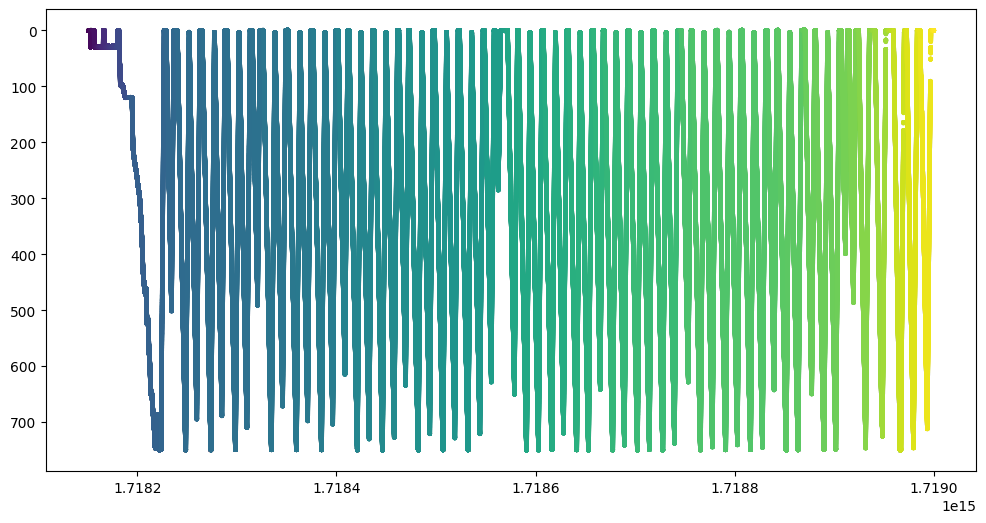

In [7]:
#Filter on valid profile numbers (profile_num > 0) and show a plot of depth vs time colored by profile number
valid_profiles = profiled_dat.filter(pl.col("profile_num") > 0) 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    valid_profiles["datetime"].to_numpy(),
    valid_profiles["depth"].to_numpy(),
    c=valid_profiles["profile_num"].to_numpy(),
    cmap="viridis",
    s=5
)
ax.invert_yaxis()

In [8]:
filtered_profiles = (
    valid_profiles
    .groupby("profile_num")
    .agg([
        pl.col("depth").min().alias("min_depth"),
        pl.col("depth").max().alias("max_depth"),
    ])
    .filter(
        (pl.col("min_depth") <= 5) & 
        (pl.col("max_depth") >= 200)
    )
)

df_clean = valid_profiles.join(filtered_profiles, on="profile_num", how="inner")

C:\Users\flapet\AppData\Local\Temp\ipykernel_28032\3347610475.py:3: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby("profile_num")


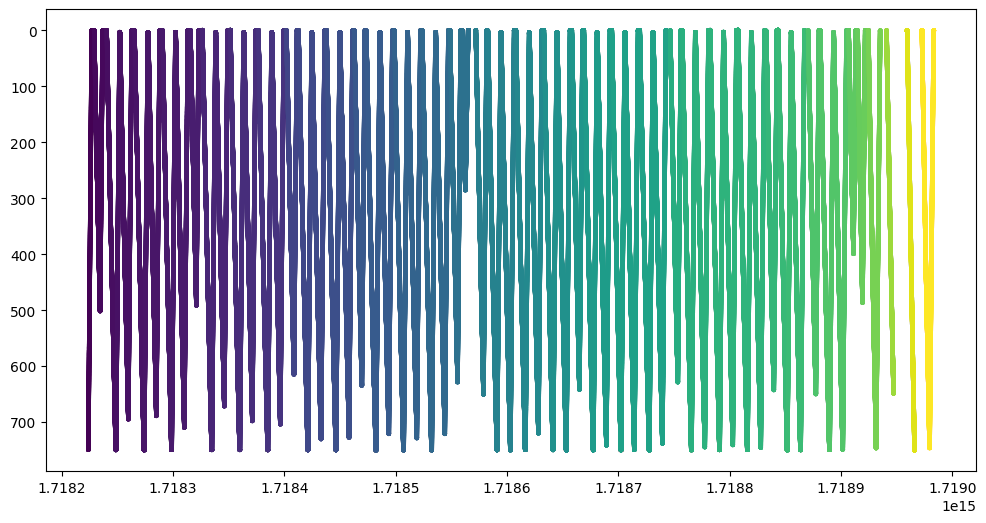

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    df_clean["datetime"].to_numpy(),
    df_clean["depth"].to_numpy(),
    c=df_clean["profile_num"].to_numpy(),
    cmap="viridis",
    s=5
)
ax.invert_yaxis()

In [10]:
# Ensure the datetime column is in datetime format before applying strftime
df_clean = df_clean.filter(~pl.col("datetime").is_nan())
df_clean = df_clean.with_columns(
    pl.col("datetime").cast(pl.Datetime("us"))
)

In [11]:
#left join df_clean onto dat
df_clean = df_clean.join(dat, on=["datetime", "depth"], how="left")

## Find daily PAR values

In [12]:
# Directory where your NetCDF files are stored (daily files)
ncdf_dir = "C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/satellite/par_09_2025/"

# List all NetCDF files for the year (one file per day)
ncdf_files = sorted([f for f in os.listdir(ncdf_dir) if f.endswith('.nc')])

# Load the PAR data for each file and store it
daily_par_data = {}
for file in ncdf_files:
    # Open the dataset for the specific day
    ds = xr.open_dataset(os.path.join(ncdf_dir, file))
    
    # Extract PAR data (assuming it's named 'par', adjust if necessary)
    # Add a date key to use as the dictionary key for each day
    date = file.split('.')[1] # Extract the date from the filename (adjust based on filename format)
    
    # Store the data in a dictionary, with the date as the key
    daily_par_data[date] = ds["par"]  # Replace 'par' with the actual variable name in your files


In [13]:
df_clean = df_clean.with_columns(
    pl.col("lon")
        .replace("NA", None)
        .cast(pl.Float64)
        .alias("lon"),
    pl.col("lat")
        .replace("NA", None)
        .cast(pl.Float64)
        .alias("lat")
)

In [14]:
#Make a table of average lon and lat for each day
df_daily = (
    df_clean
    .with_columns(
        pl.col("datetime").cast(pl.Datetime("us")).alias("dt"),
    )
    # keep points between 10:00 and 19:00
    .filter(
        pl.col("dt").dt.hour().is_between(10, 19, closed="both")
    )
    # extract date part (without time)
    .with_columns(
        pl.col("dt").dt.date().alias("date")
    )
    # group by date and compute averages
    .groupby("date")
    .agg([
        pl.col("lon").mean().alias("avg_lon"),
        pl.col("lat").mean().alias("avg_lat"),
    ])
    .sort("date")
)

C:\Users\flapet\AppData\Local\Temp\ipykernel_28032\2082850318.py:16: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby("date")


In [15]:
def get_nearest_par(lat, lon, date, daily_par_data):
    """Find the nearest PAR value for a given lat, lon, and date."""
    if date in daily_par_data and daily_par_data[date].size > 0:
        par_data = daily_par_data[date]
        nearest_par = par_data.sel(lon=lon, lat=lat, method='nearest').values.flatten()[0]
    else:
        nearest_par = 0
    return nearest_par


# Compute PAR only for unique combinations
unique_obs = df_daily.with_columns(
    pl.struct(["avg_lat", "avg_lon", "date"]).apply(
        lambda row: get_nearest_par(
            row["avg_lat"], row["avg_lon"], row["date"].strftime('%Y%m%d'),
            daily_par_data
        )
    ).alias("satellite_par")
)


C:\Users\flapet\AppData\Local\Temp\ipykernel_28032\3552118124.py:13: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.struct(["avg_lat", "avg_lon", "date"]).apply(


In [16]:
#Left join unique_obs to df_clean, need to create a date column in df_clean first
df_clean = df_clean.with_columns(
    pl.col("datetime").dt.date().alias("date")
)
df_clean = df_clean.join(unique_obs, on="date", how="left")

## Compute bbp from beta

In [17]:
df_clean = df_clean.with_columns(
    pl.col("beta").
    replace("NA", None).
    cast(pl.Float64))

In [18]:
theta = 124
xfactor = 1.076
bbp700 = gt.flo_functions.flo_bback_total(df_clean["beta"], 8, 35, theta, 700, xfactor) 

## Smoothing bbp 700
bbp_baseline, bbp_spikes = gt.cleaning.despike(bbp700, 7, spike_method='minmax')

C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [19]:
#add bbp700, bbp_baseline and bbp_spikes as columns in df_clean
df_clean = df_clean.with_columns(
    pl.Series(bbp700).alias("bbp700"),
    pl.Series(bbp_baseline).alias("bbp_baseline"),
    pl.Series(bbp_spikes).alias("bbp_spikes")
)

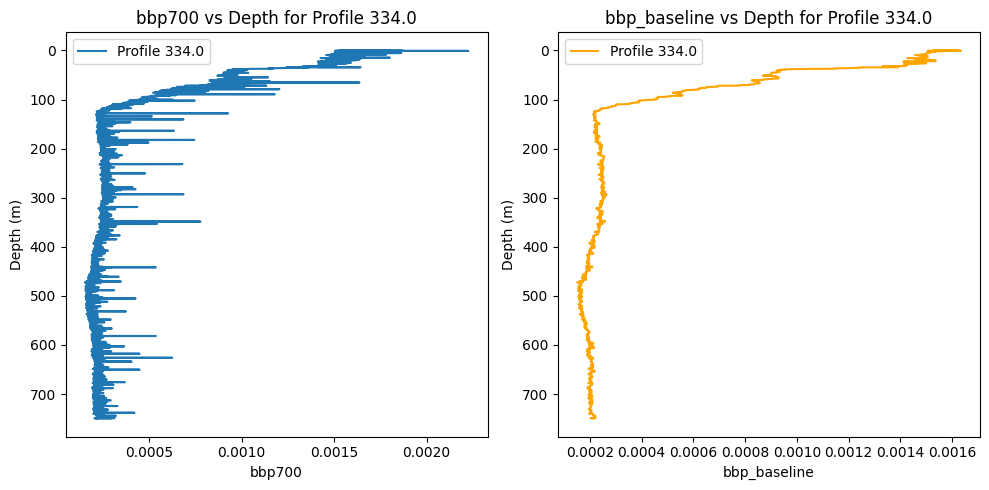

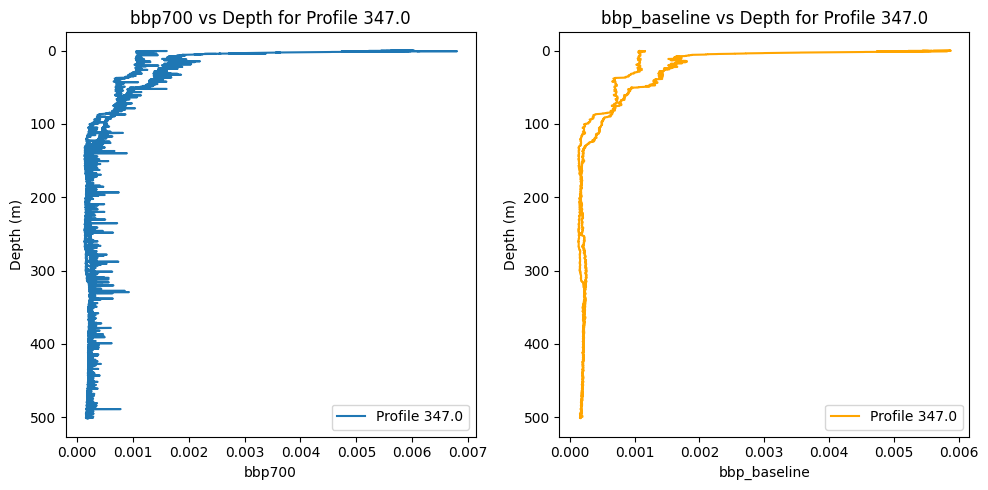

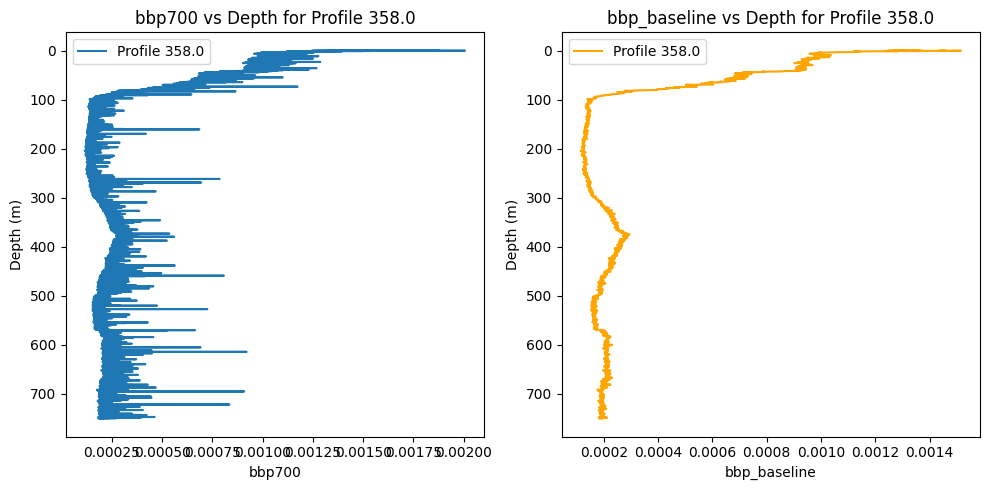

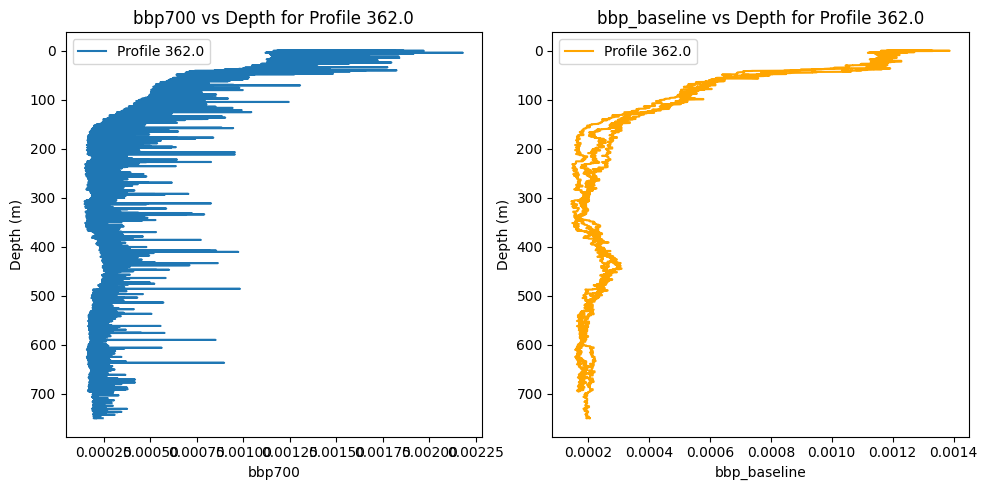

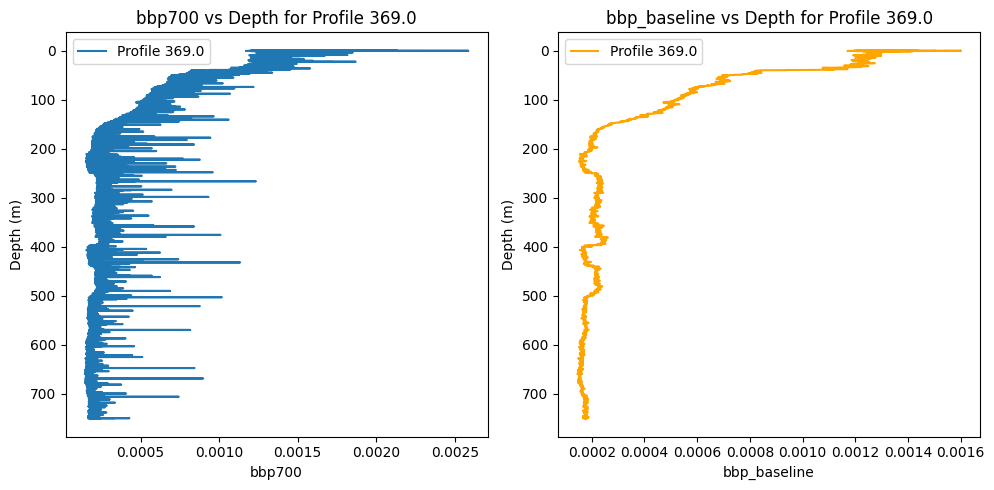

In [20]:
#Plot few profiles of bbp700 vs depth and bbp_baseline vs depth
import matplotlib.pyplot as plt
# Select a few unique profile numbers to plot
unique_profiles = df_clean["profile_num"].unique().to_list()[:5]
for profile_num in unique_profiles:
    profile_data = df_clean.filter(pl.col("profile_num") == profile_num)
    
    plt.figure(figsize=(10, 5))
    
    # Plot bbp700 vs depth
    plt.subplot(1, 2, 1)
    plt.plot(profile_data["bbp700"], profile_data["depth"], label=f'Profile {profile_num}')
    plt.gca().invert_yaxis()
    plt.xlabel('bbp700')
    plt.ylabel('Depth (m)')
    plt.title(f'bbp700 vs Depth for Profile {profile_num}')
    plt.legend()
    
    # Plot bbp_baseline vs depth
    plt.subplot(1, 2, 2)
    plt.plot(profile_data["bbp_baseline"], profile_data["depth"], label=f'Profile {profile_num}', color='orange')
    plt.gca().invert_yaxis()
    plt.xlabel('bbp_baseline')
    plt.ylabel('Depth (m)')
    plt.title(f'bbp_baseline vs Depth for Profile {profile_num}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


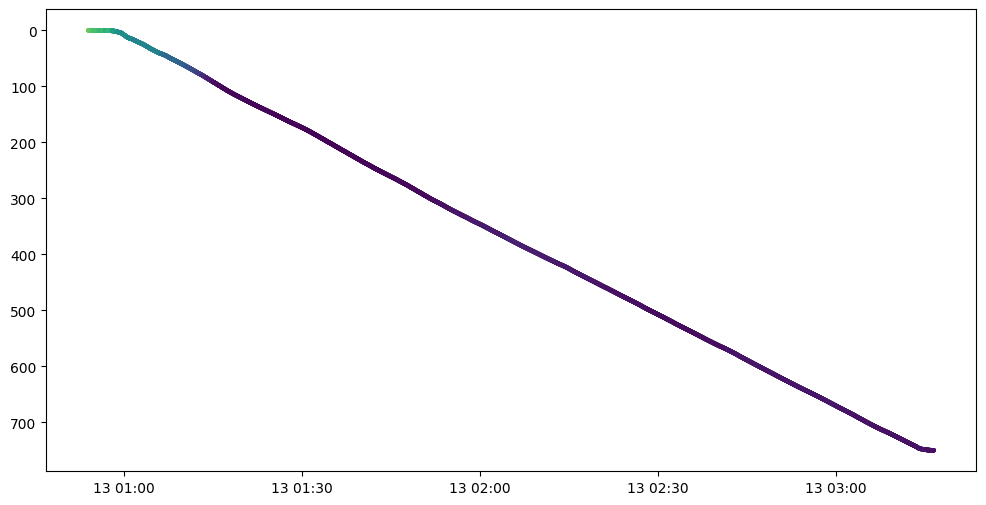

In [21]:
#plot depth vs time for profile 189
profile_189 = df_clean.filter(pl.col("profile_num") == 358)
plt.figure(figsize=(12, 6))
plt.scatter(
    profile_189["datetime"].to_numpy(),
    profile_189["depth"].to_numpy(),
    c=profile_189["bbp700"].to_numpy(),
    cmap="viridis",
    s=5
)
plt.gca().invert_yaxis()

In [22]:
# Filter profiles that last more than 3 hours
from datetime import timedelta

df_clean = df_clean.with_columns(
    pl.col("datetime").cast(pl.Datetime("us")).alias("dt_datetime"),
)

# Group by profile_num and calculate the duration of each profile
profile_durations = (
    df_clean.groupby("profile_num")
    .agg(
        (pl.col("dt_datetime").max() - pl.col("dt_datetime").min()).alias("duration")
    )
)

# Filter profiles with a duration of at least 3 hours
valid_profiles = profile_durations.filter(pl.col("duration") >= timedelta(hours=3))

# Join the valid profiles back to the original dataframe
df_clean = df_clean.join(valid_profiles, on="profile_num", how="inner")

C:\Users\flapet\AppData\Local\Temp\ipykernel_28032\3438029196.py:10: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df_clean.groupby("profile_num")


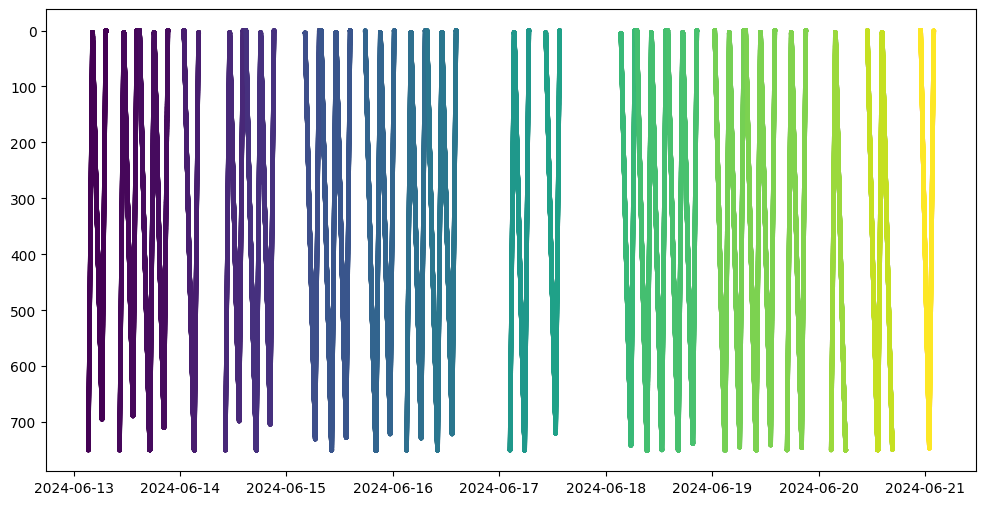

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    df_clean["datetime"].to_numpy(),
    df_clean["depth"].to_numpy(),
    c=df_clean["profile_num"].to_numpy(),
    cmap="viridis",
    s=5
)
ax.invert_yaxis()

In [24]:
#filter df_clean to keep only rows with profile_num not nan
df_clean = df_clean.filter(~pl.col("profile_num").is_nan())

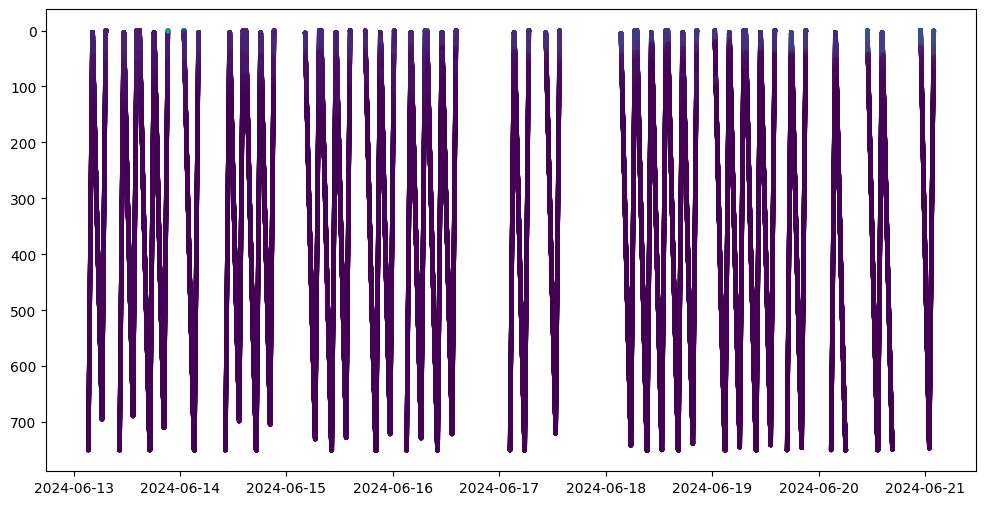

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    df_clean["datetime"].to_numpy(),
    df_clean["depth"].to_numpy(),
    c=df_clean["bbp_baseline"].to_numpy(),
    cmap="viridis",
    s=5
)
ax.invert_yaxis()

In [26]:
#select columns to keep
df_clean = df_clean.select(["datetime", "depth", "lon", "lat", "profile_num", "satellite_par", "bbp700", "bbp_baseline", "bbp_spikes", "beta"])

In [27]:
#write df_clean to csv
df_clean.write_csv("../output/ALR6_fluorometer_data_cleaned.csv")